## 1. 패키지 불러오기

In [32]:
import re
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from tqdm import tqdm

## 2. 데이터 불러오기

In [33]:
txt_list = glob.glob("./data/lyrics/*")

raw_corpus = []

for file in txt_list:
    with open(file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        
print(f"데이터 크기 : {len(raw_corpus)}")

데이터 크기 : 187088


## 3. 텍스트 전처리 - 소문자화, 불용어 제거

In [34]:
# 빈칸 제거
raw_corpus = [i for i in raw_corpus if len(i) != 0]
len(raw_corpus)

175986

In [35]:
# https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html
def text_preprocessing(corpus):
    """
    desc: 
        -소문자화, 특수문제제거, 불용어제거, Stemming 기법들 적용하여 전처리 실시
    args:
        - list()
    return:
        - list()
    """
    corpus = corpus.lower()
    corpus = re.sub('[^a-z?\'!.,¿]+', ' ', corpus)
    
    # 혼자 있는 따옴표 제거
    corpus = re.sub(' \' ', ' ', corpus)

    
    # 혼자있는 자음 제거
    tmp = None
    while tmp != corpus:
        tmp = corpus
        corpus = re.sub(" [xobgnerclfpkyvjhwzqstmd] ", ' ', corpus)
    
    corpus = re.sub("^[u] ", "you", corpus)
    corpus = re.sub(" [u]$", "you", corpus)
    corpus = re.sub("[ ]+", ' ', corpus)
    corpus = corpus.strip()
    
    
    # u를 you로 전환
    # corpus = re.sub("^<start> u ", '<start> you ', corpus)
    # corpus = re.sub(" u <end>$", ' you <end>', corpus)
    corpus = '<start> ' + corpus + ' <end>'
    corpus = corpus.strip()
    return corpus

# 전처리 적용
tmp = list(map(text_preprocessing, raw_corpus))
# 전처리 적용 후 단어가 없는 경우 제거
clean_corpus = []
for i in tmp:
    if len(i.split(" ")) > 2:
        clean_corpus += [i]

In [5]:
print(f"데이터 크기 : {len(clean_corpus)}")

데이터 크기 : 175986


## 4. 텍스트 전처리 - 토큰화, 벡터화

In [6]:
def count_vocabulary(clean_corpus):
    split_corpus = list(map(lambda x : x.split(),clean_corpus))

    tmp = defaultdict()
    for corpus in split_corpus:
        for word in corpus:
            if word not in tmp:
                tmp[word] = corpus.count(word)
            else:
                tmp[word] += corpus.count(word)

    tmp = dict(tmp)
    word_count = sorted(tmp.items(), key = lambda x : x[1], reverse = True)
    return split_corpus, word_count

split_corpus, word_count = count_vocabulary(clean_corpus)

In [7]:
def vocab(word_count, num=7000):
    """
    단어장 생성
    """
    word_index = dict()
    index_word = dict()
    for ind, i in enumerate(word_count):
        word_index[i[0]] = ind + 2
        index_word[ind + 2] = i[0]
    # padding 토큰
    word_index["<pad>"] = 0
    index_word[0] = "<pad>"
    # unknown 토큰
    word_index["<unk>"] = 1
    index_word[1] = "<unk>"

    vocab = dict(word_count[:num]) # 사용할 단어의 개수
    return vocab, word_index, index_word

vocab, word_index, index_word = vocab(word_count, num = 14000)

def vectorization(split_corpus, vocab, maxlen = None):
    """
    텍스트 말뭉치에서 벡터 말뭉치로 전환시키며 없는 단어는 <unk> 부여
    """
    vector_corpus = []
    for corpus in tqdm(split_corpus):
        tmp = []
        if len(corpus) < 15:
            for word in corpus:
                if word in vocab:
                    tmp += [word_index[word]]
                else:
                    tmp += [1]
            vector_corpus += [tmp]


    vector_corpus = tf.keras.preprocessing.sequence.pad_sequences(vector_corpus, maxlen, padding="pre")
    return vector_corpus

vector_corpus = vectorization(split_corpus, vocab)

100%|██████████| 175986/175986 [00:00<00:00, 205176.08it/s]


In [8]:
vector_corpus.shape

(158835, 14)

In [9]:
vector_corpus

array([[    0,     0,     0, ...,    51,    61,     3],
       [    0,     0,     0, ...,    17,    17,     3],
       [    0,     0,     0, ...,   101, 12040,     3],
       ...,
       [    0,     0,     0, ...,    30,   114,     3],
       [    0,     0,     0, ...,    10,   163,     3],
       [    2,     7,    40, ...,   325,   325,     3]], dtype=int32)

In [ ]:
# for i, j in word_count:
#     if len(i) == 1:
#         print(i, j)

In [ ]:
# # u, x 만 있는 단어 찾기
# tmp = list(map(lambda x : len(re.findall(" q ", x)), clean_corpus))
# for i in range(len(clean_corpus)):
#     if tmp[i] != 0:
#         print(i, clean_corpus[i])

In [ ]:
# split_corpus

# from gensim.models import Word2Vec
# word2vec_model = Word2Vec(vector_size = 300, window=5, min_count = 1, workers = 2)
# word2vec_model.build_vocab(split_corpus)
# word2vec_model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

# word2vev = Word2Vec(split_corpus)

# word2vev.wv

# tmp = []
# for corpus in split_corpus[:10]:
#     tmp += [list(map(lambda x: word2vev.wv[x], corpus))]

In [10]:
print(f"문장 갯수 : {vector_corpus.shape[0]}\n문장 길이 : {vector_corpus.shape[1]}")
print(f"텍스트에서 변환된 시퀀스 가장 큰 인덱스값 : {np.max(vector_corpus)}")

문장 갯수 : 158835
문장 길이 : 14
텍스트에서 변환된 시퀀스 가장 큰 인덱스값 : 14001


## 5. 학습데이터셋, 테스트데이터셋 분리 및 구축

In [11]:
seed = 1
np.random.seed(seed)
random_index = np.random.choice(range(len(vector_corpus)), 20000, replace=False)
mini_vector_corpus = vector_corpus[random_index]

In [24]:
src_input = vector_corpus[:, :-1]
tgt_input = vector_corpus[:, 1:]

tr_src_input,te_src_input,tr_tgt_input,te_tgt_input = train_test_split(src_input,
                                                                      tgt_input,
                                                                      test_size = 0.2,
                                                                      random_state = seed) 

In [25]:
print(tr_src_input.shape, tr_tgt_input.shape)
print(te_src_input.shape, te_tgt_input.shape)

(127068, 13) (127068, 13)
(31767, 13) (31767, 13)


In [26]:
buffer_size = len(tr_src_input)
batch_size = 64
steps_per_epoch = len(tr_src_input) // batch_size

vocab_size = len(word_count)
dataset = tf.data.Dataset.from_tensor_slices((tr_src_input, tr_tgt_input))
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 13), (64, 13)), types: (tf.int32, tf.int32)>

## 6. 모델 구조 구축

In [44]:
def create_model():
    embedding_size = 256
    hidden_size = 1024

    inputs = tf.keras.layers.Input(shape=(tr_src_input.shape[1]))
    layer = tf.keras.layers.Embedding(vocab_size, embedding_size)(inputs)
#   layer = tf.keras.layers.BatchNormalization()(layer) 
    layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True)(layer)
#   layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True, dropout=0.2)(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)

#   layer = tf.keras.layers.BatchNormalization()(layer) 
    layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True)(layer)
#   layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True, dropout=0.2)(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)

#   layer = tf.keras.layers.BatchNormalization()(layer)
    outputs = tf.keras.layers.Dense(vocab_size, kernel_initializer="he_normal")(layer)
#   outputs = tf.keras.layers.Dense(vocab_size)(layer)

    model = tf.keras.Model(inputs, outputs)
    return model

## 7. 모델 학습

Epoch 1/10
1985/1985 [==============================] - 489s 245ms/step - loss: 3.7693 - val_loss: 3.1054
Epoch 2/10
1985/1985 [==============================] - 486s 245ms/step - loss: 3.0089 - val_loss: 2.8580
Epoch 3/10
1985/1985 [==============================] - 486s 245ms/step - loss: 2.7026 - val_loss: 2.7032
Epoch 4/10
1985/1985 [==============================] - 485s 244ms/step - loss: 2.4324 - val_loss: 2.6010
Epoch 5/10
1985/1985 [==============================] - 485s 244ms/step - loss: 2.2169 - val_loss: 2.5302
Epoch 6/10
1985/1985 [==============================] - 485s 244ms/step - loss: 2.0353 - val_loss: 2.4892
Epoch 7/10
1985/1985 [==============================] - 486s 245ms/step - loss: 1.8900 - val_loss: 2.4620
Epoch 8/10
1985/1985 [==============================] - 485s 244ms/step - loss: 1.7681 - val_loss: 2.4491
Epoch 9/10
1985/1985 [==============================] - 486s 245ms/step - loss: 1.6716 - val_loss: 2.4380
Epoch 10/10
1985/1985 [=======================

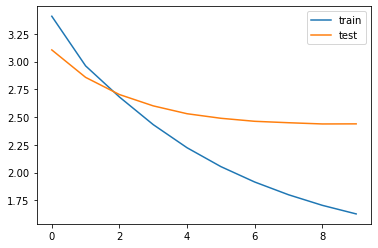

In [45]:
# Adam은 적응적 학습률 알고리즘이기에 학습률 파라미터의 튜닝의 필요성이 적습니다. - 핸즈온 머신러닝 441p
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-5, min_delta=0.05)



model = create_model()
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, 
                    validation_data = (te_src_input, te_tgt_input),
                    callbacks=[es],
                    epochs=10)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [47]:
model.save("./model/saved_model_dropout0_2.h5")

## 8. 학습된 모델 확인

In [49]:
def generate_setence(init_setence, max_len = 20):
    init_sentence = [init_setence.split()]
    test_tensor = vectorization(init_sentence, vocab, te_src_input.shape[1])

    while True:
        # 1
        predict = model.predict(test_tensor)
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == word_index["<end>"]: break
        if test_tensor.shape[1] >= max_len: break

    pred_sentence = test_tensor.numpy()[0]
    for ind, i in enumerate(pred_sentence):
        if i != 0:
            tmp = pred_sentence[ind:]
            break

    return " ".join([index_word[index] for index in tmp])

generate_setence("<start> i love")

100%|██████████| 1/1 [00:00<00:00, 7639.90it/s]


'<start> i love <end>'

## 모델 성능 개선을 위한 노력
- 하이퍼 파라미터 조절
    1. vocab 사이즈 조절
    2. embedding 사이즈 조절
    3. hidden state 크기 조절
- 텍스트 데이터 전처리
- 외부 모델 불러오기

## 하이퍼 파라미터 조절

vocab size를 20,000 embedding size를 256 hidden state 크기를 1024로 하여 단순히 하이퍼 파라미터를 크게 한다고 좋은게 아니라고 느꼈습니다.

sentence: 10000  
vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.2 loss: 3.5306 - val_loss: 3.8973  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.05 loss: 3.5625 - val_loss: 3.9262  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.6373 - val_loss: 3.8414  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.8 loss: 3.8938 - val_loss: 3.8881 다시 val_loss가 상승함  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.3754 - val_loss: 4.2197 batchnormalization  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5693 - val_loss: 3.8093 ReduceLROnPlateau  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 1개 epoch 9   

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.6421 - val_loss: 3.8326 ReduceLROnPlateau batchnormalization 2개   


sentence: full  
vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 2개 

sentence: 20000  
vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 2개 batch_size: 64

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 1개 batch_size: 64

loss: 1.9850 - val_loss: 3.2193

## 텍스트 데이터 전처리

관사 a, an, the를 제외한 길이가 1인 단어는 모두 제거하기

중복되는 문장 제거하기는 오히려 성능의 저하가 발생하여 중복제거는 안하는 것이 좋다는 것을 알았습니다.  
중복 제거 전 : loss: 3.5905 - val_loss: 3.8269  
중복 제거 후 : loss: 3.9458 - val_loss: 4.1933

배치사이즈를 적절하게 줄여야지 모델의 학습이 제대로 이루어져서 loss값이 감소하는 것을 알았습니다.
- why? 배치사이즈를 줄임으로써 그래디언트가 갱신되는 횟수가 증가하여 수렴지점으로 더 쉽게 지나가기 때문이지 않을까?

unknown 토큰을 추가하자 train loss값이 착실하게 감소하게 되었습니다.

start 토큰과 end토큰을 제거하고 하는것이 더 학습이 잘됩니다.